In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
def read_directory(dir):
    res = []
    for filename in os.listdir(dir):
        with open(dir+filename) as file:
            res.append((filename.split('.')[0], file.read()))
    return res

def read_labeled(pos_dir, neg_dir):
    df_train_pos = pd.DataFrame.from_records(read_directory(pos_dir), index="id", columns=("id", "review"))
    df_train_pos["positive"] = True
    df_train_neg = pd.DataFrame.from_records(read_directory(neg_dir), index="id", columns=("id", "review"))
    df_train_neg["positive"] = False
    return pd.concat((df_train_pos, df_train_neg))

In [3]:
df_train = read_labeled("./aclImdb/train/pos/", "./aclImdb/train/neg/")
df_train

,review,positive
id,,
0_9,Bromwell High is a cartoon comedy. It ran at t...,True
10000_8,Homelessness (or Houselessness as George Carli...,True
10001_10,Brilliant over-acting by Lesley Ann Warren. Be...,True
10002_7,This is easily the most underrated film inn th...,True
10003_8,This is not the typical Mel Brooks film. It wa...,True
...,...,...
9998_4,"Towards the end of the movie, I felt it was to...",False
9999_3,This is the kind of movie that my enemies cont...,False
999_3,I saw 'Descent' last night at the Stockholm Fi...,False


In [4]:
df_train.review.map(lambda x: len(x)).describe()

count    25000.00000
mean      1325.06964
std       1003.13367
min         52.00000
25%        702.00000
50%        979.00000
75%       1614.00000
max      13704.00000
Name: review, dtype: float64

In [5]:
df_train.review[df_train.review.map(lambda x: len(x)).idxmax()]

'Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then set up for a double superplex from the middle rope which would have put Bubba through the table, bu

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split


In [7]:
from sklearn.calibration import CalibratedClassifierCV

In [8]:
x_train,x_test,y_train,y_test = train_test_split(df_train.review, df_train.positive, test_size = 0.2)

In [9]:
Classifier_svc = Pipeline([
    ('tfIdf', TfidfVectorizer(
        max_df=0.95,
        min_df=5,
        ngram_range=(1,2)
    )),
    ('cl', CalibratedClassifierCV(LinearSVC())),
    # ('classifier', LogisticRegression())
    # ('classifier', GradientBoostingClassifier(n_estimators=100, max_depth=3, verbose=True, subsample=0.1))
])
Classifier_svc.fit(x_train, y_train)
pred = Classifier_svc.predict(x_test)


c:\Users\Abstract\mambaforge\envs\sentenv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Abstract\mambaforge\envs\sentenv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Abstract\mambaforge\envs\sentenv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Abstract\mambaforge\envs\sentenv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warning

[[2244  264]
 [ 228 2264]]


Accuracy :  0.9016


              precision    recall  f1-score   support

       False       0.91      0.89      0.90      2508
        True       0.90      0.91      0.90      2492

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



<Axes: >

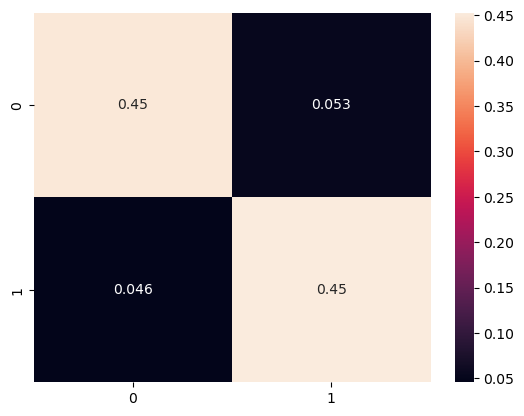

In [10]:
cm = confusion_matrix(y_test, pred)
print(cm)
print('\n')

print("Accuracy : ", accuracy_score(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

sns.heatmap(cm/cm.sum(), annot=True)


In [11]:
print(Classifier_svc.predict_proba(["I viewed this movie! Absolutely Stunning! Will go to watch it again, eww the film not looking at all, actors played their role"]))

[[0.41811443 0.58188557]]


In [12]:
tfidf = Classifier_svc.steps[0][1]

In [13]:
len(tfidf.vocabulary_)

129884

In [40]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, XLNetForSequenceClassification, XLNetModel


In [46]:
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=1).to('cuda')

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [48]:
for param in model.transformer.parameters():
    param.requires_grad = False


In [49]:
inputs = tokenizer(df_train.review[df_train.review.map(lambda x: len(x)).idxmax()], return_tensors="pt").to('cuda')
# inputs = tokenizer(df_train.review[1], return_tensors="pt")
inputs['input_ids'].shape

torch.Size([1, 3251])

In [53]:
with torch.no_grad():
    outputs = model(**inputs)
outputs


XLNetForSequenceClassificationOutput(loss=None, logits=tensor([[-0.4477]], device='cuda:0'), mems=(tensor([[[-0.0513, -0.0276, -0.1103,  ...,  0.0411, -0.0054, -0.0982]],

        [[ 0.0205,  0.0293,  0.0087,  ..., -0.0801,  0.0118,  0.0319]],

        [[ 0.0021, -0.0177, -0.0014,  ..., -0.0916, -0.0789, -0.0094]],

        ...,

        [[-0.0431,  0.0640,  0.0226,  ...,  0.0488, -0.0137,  0.1968]],

        [[ 0.0788, -0.0583, -0.0905,  ...,  0.0493,  0.0634, -0.0520]],

        [[ 0.0181, -0.0015, -0.1494,  ...,  0.0012, -0.0009,  0.0188]]],
       device='cuda:0'), tensor([[[-0.5865, -0.3098, -2.5139,  ...,  0.5070, -0.6107, -1.6163]],

        [[ 1.1259,  1.2640,  0.4473,  ..., -2.0993,  0.1832,  0.4794]],

        [[ 0.0534, -0.8553, -0.8281,  ..., -1.5194, -1.2074, -0.7259]],

        ...,

        [[-0.4726,  0.9488,  0.1310,  ...,  0.7502, -0.3187,  2.9045]],

        [[ 1.2140, -0.8248, -1.4698,  ...,  0.7650,  0.4106, -0.0954]],

        [[ 0.5497, -0.2334, -2.3614,  ...,  0

In [20]:
outputs.last_hidden_state.shape


AttributeError: 'XLNetForSequenceClassificationOutput' object has no attribute 'last_hidden_state'

In [ ]:
del outputs
torch.cuda.empty_cache() 

In [ ]:
del model

In [54]:
import datasets

In [55]:
dataset = datasets.Dataset.from_pandas(df_train)

In [56]:
dataset

Dataset({
    features: ['review', 'positive', 'id'],
    num_rows: 25000
})

In [57]:
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = dataset["test"].shuffle(seed=42).select(range(1000))

KeyError: "Column train not in the dataset. Current columns in the dataset: ['review', 'positive', 'id']"